## 1 导包定义文件变量

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ACTION_201602_FILE = "JD_data/JData_Action_201602.csv"
ACTION_201603_FILE = "JD_data/JData_Action_201603.csv"
ACTION_201604_FILE = "JD_data/JData_Action_201604.csv"
COMMENT_FILE = "JD_data/JData_Comment.csv"
PRODUCT_FILE = "JD_data/JData_Product.csv"
USER_FILE = "JD_data/JData_User.csv"

## 2 周一到周日各天购买情况

### 2.1 定义提取购买数据函数

In [2]:
# 提取购买(type =4)的行为数据
# pandas加载数据，批量加载数据
def get_from_action_data(fname,chunk_size=50000):
    reader = pd.read_csv(fname,header=0,iterator=True) # 不是直接数据
    chunks = []
    loop =True
    while loop:
        try:
            chunk = reader.get_chunk(chunk_size)[
                ["user_id","sku_id","type","time"]]
            chunks.append(chunk)
        except StopIteration:
            loop = False
            print("Iteration is stopped")
    df_ac = pd.concat(chunks,ignore_index=True)
    # type =4 ，为购买
    df_ac = df_ac[df_ac['type'] == 4]
    return df_ac[["user_id", "sku_id", "time"]]

### 2.2 提取全部购买数据

In [3]:
df_ac = []
df_ac.append(get_from_action_data(fname=ACTION_201602_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201603_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201604_FILE))

df_ac = pd.concat(df_ac,ignore_index=True)
display(df_ac.head(),df_ac.shape)

Iteration is stopped
Iteration is stopped
Iteration is stopped


,user_id,sku_id,time
0,269365,166345,2016-02-01 00:01:00
1,235443,36692,2016-02-01 00:02:00
2,247689,9112,2016-02-01 00:03:00
3,273959,102034,2016-02-01 00:05:00
4,226791,163550,2016-02-01 00:06:00


(48252, 3)

### 2.3 日期转换

In [4]:
#由于time是object类型，我们想要查看时间得把它的时间进行转换一下
df_ac.dtypes

user_id     int64
sku_id      int64
time       object
dtype: object

In [5]:
#将time字符按转换为datetime类型
df_ac['time'] = pd.to_datetime(df_ac['time'])

display(df_ac.head(),df_ac.dtypes)

,user_id,sku_id,time
0,269365,166345,2016-02-01 00:01:00
1,235443,36692,2016-02-01 00:02:00
2,247689,9112,2016-02-01 00:03:00
3,273959,102034,2016-02-01 00:05:00
4,226791,163550,2016-02-01 00:06:00


user_id             int64
sku_id              int64
time       datetime64[ns]
dtype: object

In [6]:
df_ac['time'] = df_ac['time'].apply(lambda x: x.weekday() +1)
df_ac.head()

,user_id,sku_id,time
0,269365,166345,1
1,235443,36692,1
2,247689,9112,1
3,273959,102034,1
4,226791,163550,1


In [7]:
df_ac['time'].unique()

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

### 2.4 分组聚合汇总

In [8]:
#从周一到周日每天购买用户个数
df_user = df_ac.groupby('time')['user_id'].nunique() # 去重
display(df_user.head()) #Series

# to_frame(),将Series变成DataFrame
# reset_index() 重置索引，行索引从0开始
df_user = df_user.to_frame().reset_index()
df_user.columns = ['weekday','user_num']
df_user

time
1    6162
2    6946
3    5001
4    6409
5    6049
Name: user_id, dtype: int64

,weekday,user_num
0,1,6162
1,2,6946
2,3,5001
3,4,6409
4,5,6049
5,6,4174
6,7,3710


In [9]:
# 周一到周日每天购买商品的个数
df_item = df_ac.groupby('time')['sku_id'].nunique()

df_item = df_item.to_frame().reset_index()
df_item.columns = ['weekday','item_num']
df_item

,weekday,item_num
0,1,1844
1,2,1996
2,3,1800
3,4,1805
4,5,1855
5,6,1643
6,7,1578


In [10]:
# 周一到周日每天购买记录个数
df_ui = df_ac.groupby('time',as_index=False).size()

df_ui.columns = ['weekday','user_item_num']
df_ui

,weekday,user_item_num
0,1,7759
1,2,8869
2,3,6262
3,4,8078
4,5,7505
5,6,5143
6,7,4636


### 2.5 周购买情况数据可视化

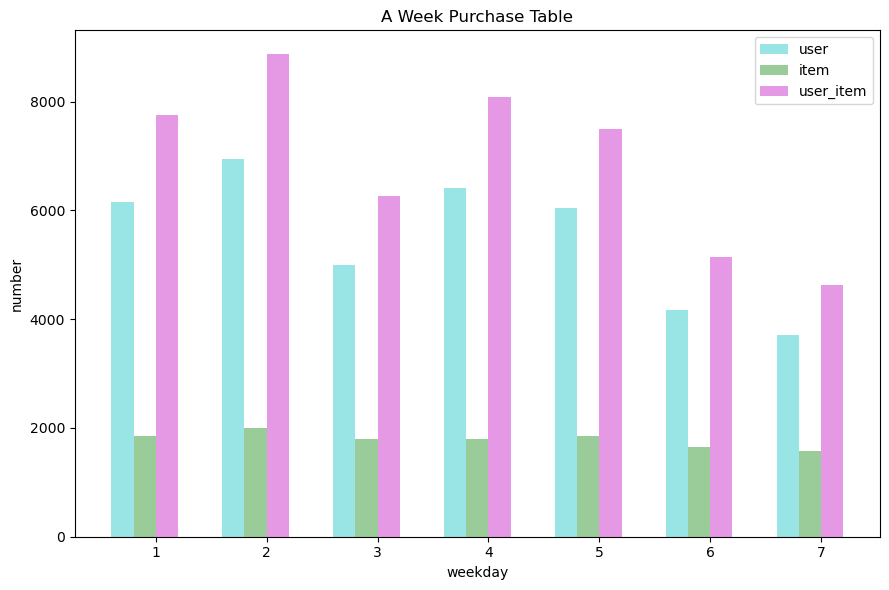

In [11]:
# 条形宽度
bar_width = 0.2
# 透明度
opacity = 0.4
plt.figure(figsize=(9,6))

plt.bar(df_user['weekday'],df_user['user_num'],bar_width,
        alpha = opacity,color='c',label = 'user')

plt.bar(df_item['weekday']+bar_width,df_item['item_num'],
       bar_width,alpha = opacity,color='g',label='item')

plt.bar(df_ui['weekday']+bar_width*2,df_ui['user_item_num'],
       bar_width,alpha=opacity,color='m',label='user_item')

plt.xlabel('weekday')
plt.ylabel('number')
plt.title('A Week Purchase Table')
plt.xticks(df_user['weekday'] + bar_width*3/2,(1,2,3,4,5,6,7))
plt.tight_layout()
plt.legend(prop={'size':10})

### 2.6 结论

周六，周日购买量较少（在玩，逛街，线下购物）

### 3.一个月中各天购买量

### 3.1 2016年2月

获取数据

In [12]:
df_ac = get_from_action_data(fname=ACTION_201602_FILE)
#将time字段转换为datetime类型并使用lambda匿名函数将时间time转换为天
df_ac['time'] = pd.to_datetime(df_ac['time']).apply(lambda x:x.day)
df_ac.head()

Iteration is stopped


,user_id,sku_id,time
351,269365,166345,1
649,235443,36692,1
980,247689,9112,1
1719,273959,102034,1
2153,226791,163550,1


分组聚合数据汇总

In [15]:
#每天购买用户去重数据
df_user = df_ac.groupby('time')['user_id'].nunique()
df_user = df_user.to_frame().reset_index()
df_user.columns = ['day','user_num']
df_user

,day,user_num
0,1,454
1,2,383
2,3,302
3,4,256
4,5,160
5,6,120
6,7,82
7,8,100
8,9,113
9,10,121


In [16]:
# 每天购买用户商品去重数据
df_item = df_ac.groupby('time')['sku_id'].nunique()
df_item = df_item.to_frame().reset_index()
df_item.columns = ['day','item_num']
df_item

,day,item_num
0,1,352
1,2,311
2,3,255
3,4,213
4,5,147
5,6,114
6,7,93
7,8,96
8,9,106
9,10,128


In [17]:
# 每天购买记录总数
df_ui = df_ac.groupby('time',as_index=False).size()
df_ui.columns = ['day','user_item_num']
df_ui

,day,user_item_num
0,1,539
1,2,462
2,3,357
3,4,297
4,5,179
5,6,134
6,7,107
7,8,109
8,9,127
9,10,150


2月购买情况可视化

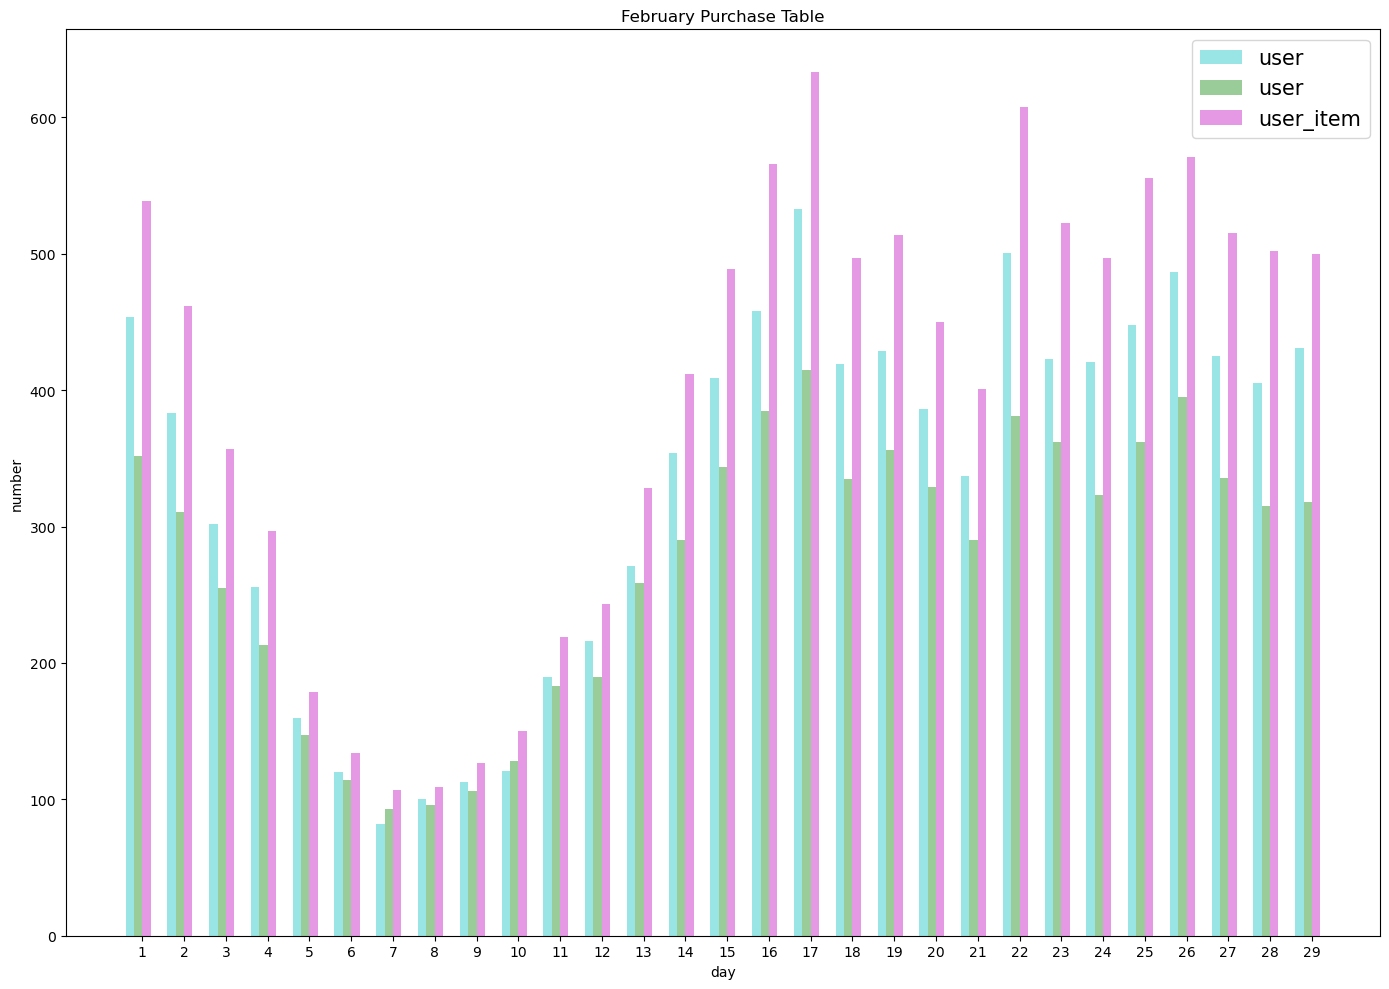

In [18]:
# 条形宽度
bar_width = 0.2
# 透明度
opacity = 0.4
# 天数
day_range = range(1,len(df_user['day'])+1)
# 设置图片大小
plt.figure(figsize=(14,10))

plt.bar(df_user['day'],df_user['user_num'],bar_width,
       alpha=opacity,color='c',label='user')

plt.bar(df_item['day']+bar_width,df_item['item_num'],bar_width,
       alpha=opacity,color='g',label='user')

plt.bar(df_user['day']+bar_width*2,df_ui['user_item_num'],bar_width,
       alpha=opacity,color='m',label='user_item')

plt.xlabel('day')
plt.ylabel('number')
plt.title('February Purchase Table')
plt.xticks(df_user['day']+bar_width*3/2.,day_range)
plt.tight_layout()
plt.legend(prop = {'size':15})

分析：2月份5，6，7，8，9，10这几天购买量非常少，原因可能是中国农历春节，快递不营业

### 3.2 2016年3月

In [19]:
df_ac = get_from_action_data(fname=ACTION_201603_FILE)
# 将time字段转换为datetime类型并使用lambda匿名函数将时间time转换为天
df_ac['time'] = pd.to_datetime(df_ac['time']).apply(lambda x: x.day)

df_user = df_ac.groupby('time')['user_id'].nunique()
df_user = df_user.to_frame().reset_index()
df_user.columns = ['day','user_num']

df_item = df_ac.groupby('time')['sku_id'].nunique()
df_item = df_item.to_frame().reset_index()
df_item.columns = ['day','item_num']

df_ui = df_ac.groupby('time',as_index=False).size()
df_ui.columns=['day','user_item_num']

Iteration is stopped


3月份购买情况可视化

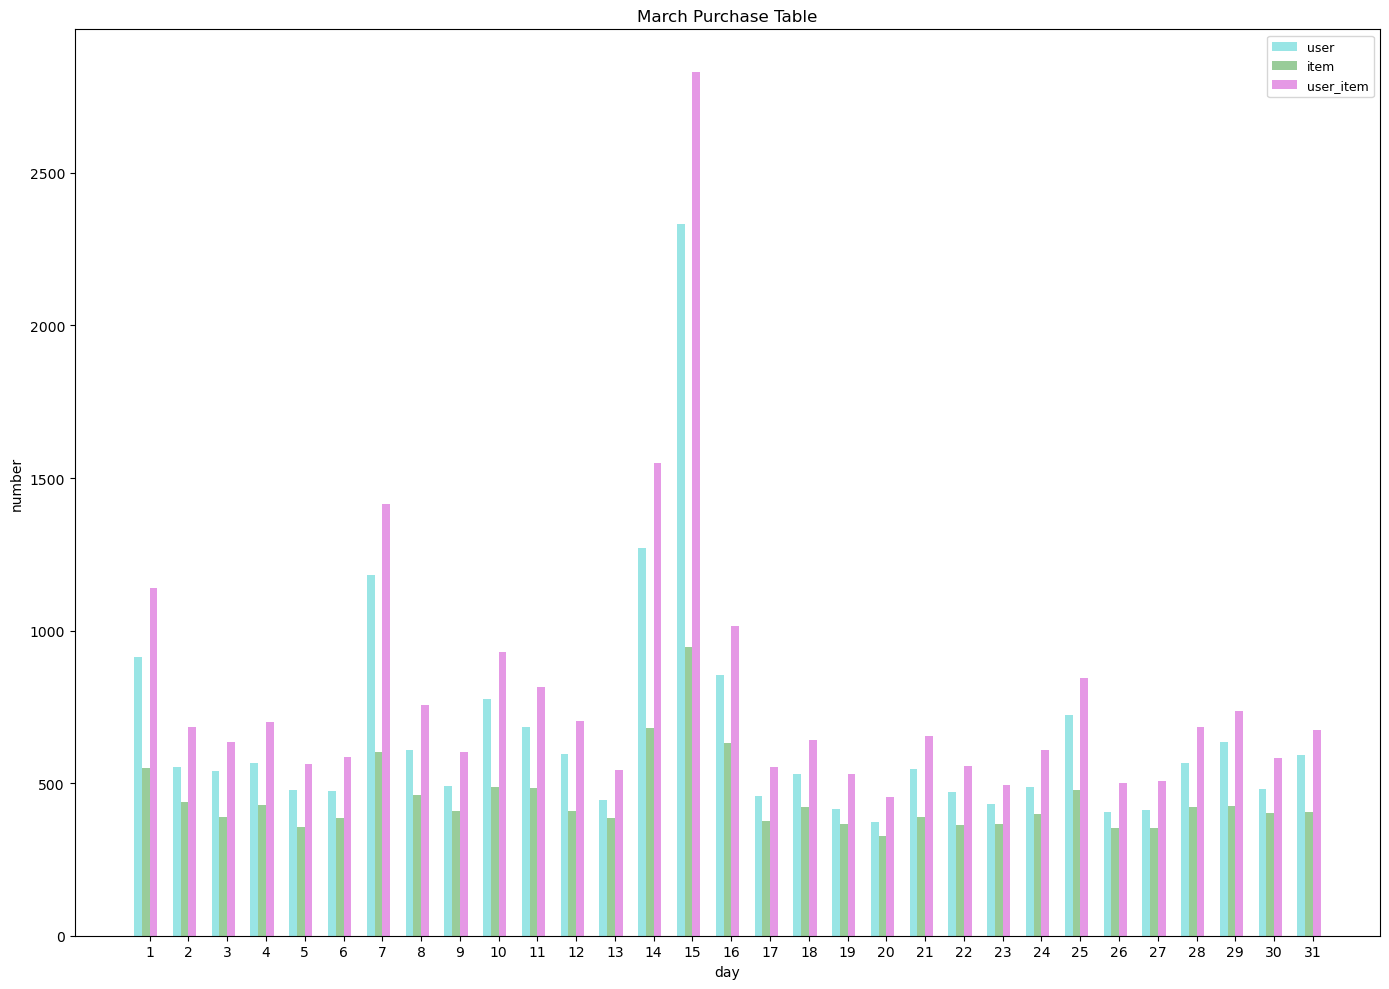

In [20]:
#条形宽度
bar = 0.2
# 透明度
opacity = 0.4
# 天数
day_range = range(1,len(df_user['day'])+1,1)
# 设置图片大小
plt.figure(figsize=(14,10))

plt.bar(df_user['day'],df_user['user_num'],bar_width,
       alpha=opacity,color = 'c',label = 'user')
plt.bar(df_item['day']+bar_width,df_item['item_num'],
       bar_width,alpha=opacity,color='g',label='item')
plt.bar(df_ui['day']+bar_width*2,df_ui['user_item_num'],
       bar_width,alpha=opacity,color='m',label='user_item')

plt.xlabel('day')
plt.ylabel('number')
plt.title('March Purchase Table')
plt.xticks(df_user['day']+bar_width*3/2,day_range)
plt.tight_layout()
plt.legend(prop = {'size':9})

分析:总体来看，购物记录多于2月份

### 3.3 2016年4月

加载数据分组聚合

In [21]:
df_ac = get_from_action_data(fname=ACTION_201604_FILE)

df_ac['time'] = pd.to_datetime(df_ac['time']).apply(lambda x:x.day)

df_user = df_ac.groupby('time')['user_id'].nunique()
df_user = df_user.to_frame().reset_index()
df_user.columns = ['day','user_num']

df_item = df_ac.groupby('time')['sku_id'].nunique()
df_item = df_item.to_frame().reset_index()
df_item.columns = ['day','item_num']

df_ui = df_ac.groupby('time',as_index=False).size()
df_ui.columns=['day','user_item_num']

Iteration is stopped


4月份购买情况的可视化

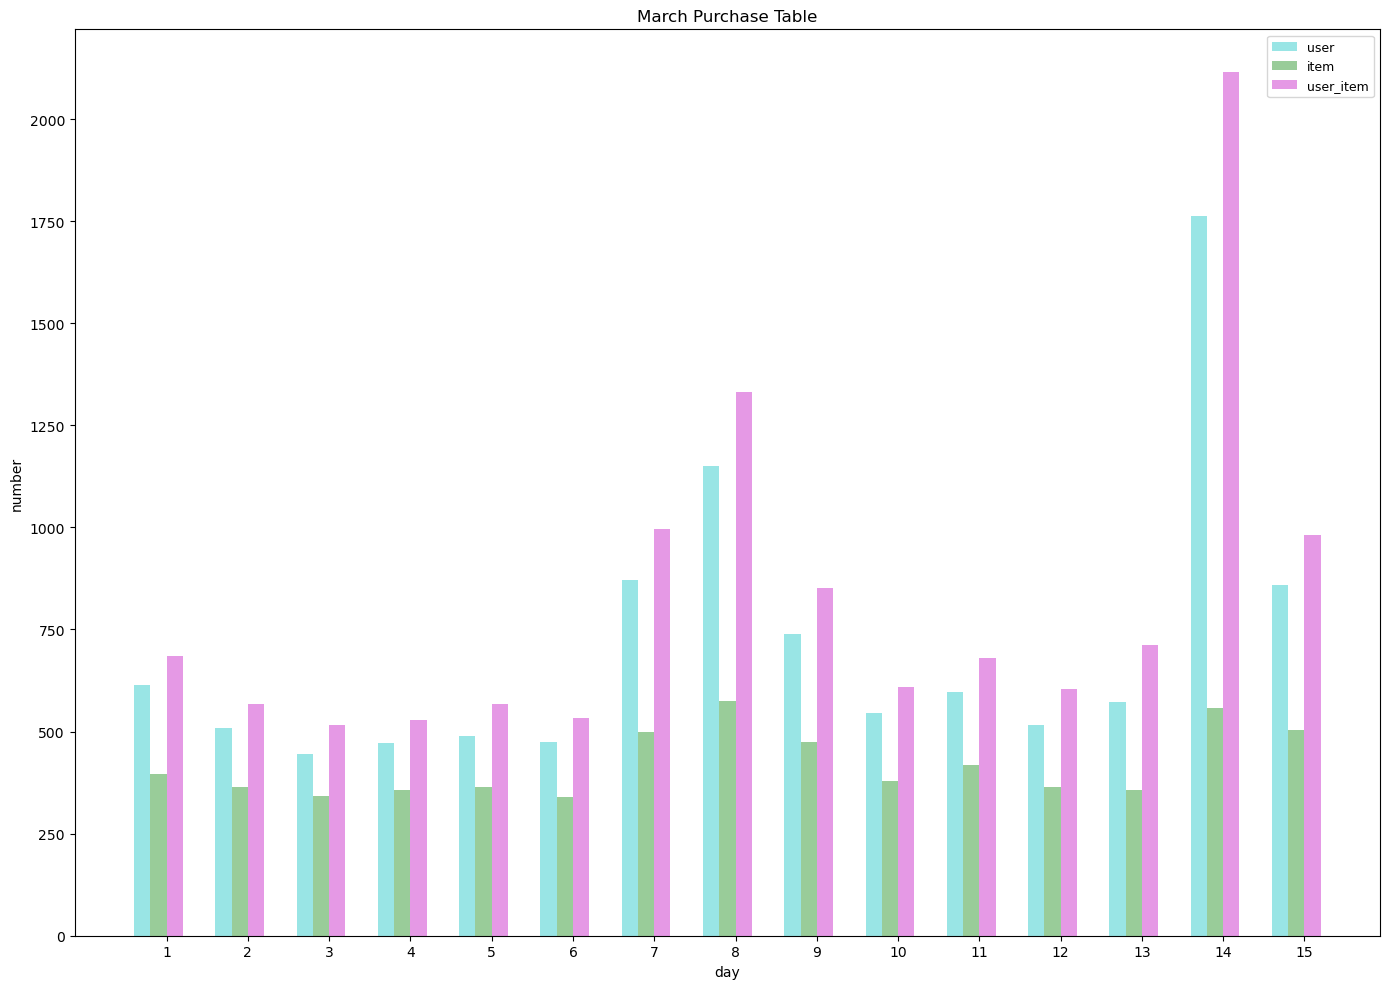

In [22]:
#条形宽度
bar = 0.2
# 透明度
opacity = 0.4
# 天数
day_range = range(1,len(df_user['day'])+1,1)
# 设置图片大小
plt.figure(figsize=(14,10))

plt.bar(df_user['day'],df_user['user_num'],bar_width,
       alpha=opacity,color = 'c',label = 'user')
plt.bar(df_item['day']+bar_width,df_item['item_num'],
       bar_width,alpha=opacity,color='g',label='item')
plt.bar(df_ui['day']+bar_width*2,df_ui['user_item_num'],
       bar_width,alpha=opacity,color='m',label='user_item')

plt.xlabel('day')
plt.ylabel('number')
plt.title('March Purchase Table')
plt.xticks(df_user['day']+bar_width*3/2,day_range)
plt.tight_layout()
plt.legend(prop = {'size':9})

分析:每个月中旬都有较强的购物欲望，适合促销！或者说，很多公司在月中发工资

## 4.定义函数提取行为记录中商品类别

### 4.1 定义函数提取行为记录中商品类别数据

In [29]:
#  从行记录中提取商品
def get_from_action_data(fname,chunk_size=50000):
    reader = pd.read_csv(fname,header=0,iterator=True)
    chunks = []
    loop = True
    while loop:
        try:
            chunk = reader.get_chunk(chunk_size)[
                ["cate","brand","type","time"]
            ]
            chunks.append(chunk)
        except StopIteration:
            loop = False
            print("Iteration is stooped")
    df_ac = pd.concat(chunks,ignore_index=True)
    #type=4,为购买
    df_ac = df_ac[df_ac['type']==4]
    
    return df_ac[["cate","brand","type","time"]]

### 4.2 提取全部商品类别数据

In [30]:
df_ac = []
df_ac.append(get_from_action_data(fname=ACTION_201602_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201603_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201604_FILE))
df_ac = pd.concat(df_ac,ignore_index=True)

#将time字段转换为datetime类型
df_ac['time'] = pd.to_datetime(df_ac['time'])
#使用lambda匿名函数将时间time转换为星期（周一为1，周日为7）
df_ac['time'] = df_ac['time'].apply(lambda x:x.weekday()+1)

#观察有几个类别商品
df_ac.groupby(df_ac['cate']).count()

Iteration is stooped
Iteration is stooped
Iteration is stooped


,brand,type,time
cate,,,
4,9326,9326,9326
5,8138,8138,8138
6,6982,6982,6982
7,6214,6214,6214
8,13281,13281,13281
9,4104,4104,4104
10,189,189,189
11,18,18,18


### 4.3 商品不同类别销量可视化

In [31]:
from matplotlib.font_manager import FontManager
fm = FontManager()
[font.name for font in fm.ttflist]

['STIXSizeFourSym',
 'cmtt10',
 'DejaVu Serif',
 'STIXGeneral',
 'DejaVu Sans',
 'STIXNonUnicode',
 'STIXNonUnicode',
 'STIXGeneral',
 'DejaVu Sans Mono',
 'cmmi10',
 'STIXGeneral',
 'DejaVu Sans Mono',
 'STIXSizeThreeSym',
 'DejaVu Serif',
 'STIXSizeOneSym',
 'STIXNonUnicode',
 'cmex10',
 'STIXGeneral',
 'DejaVu Serif',
 'cmsy10',
 'DejaVu Sans Mono',
 'STIXSizeFiveSym',
 'STIXSizeOneSym',
 'STIXSizeTwoSym',
 'DejaVu Sans Display',
 'cmss10',
 'DejaVu Sans',
 'STIXSizeThreeSym',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Serif',
 'DejaVu Sans Mono',
 'cmb10',
 'STIXNonUnicode',
 'STIXSizeFourSym',
 'STIXSizeTwoSym',
 'cmr10',
 'DejaVu Serif Display',
 'Consolas',
 'codicon',
 'Material Design Icons 5.9.55',
 'Perpetua',
 'Magneto',
 'Showcard Gothic',
 'Malgun Gothic',
 'Segoe UI',
 'Viner Hand ITC',
 'Tw Cen MT',
 'Bradley Hand ITC',
 'Comic Sans MS',
 'Font Awesome 5 Free Regular',
 'Algerian',
 'SimSun-ExtB',
 'Goudy Old Style',
 'Bookman Old Style',
 'Niagara Engraved',
 'Candara',


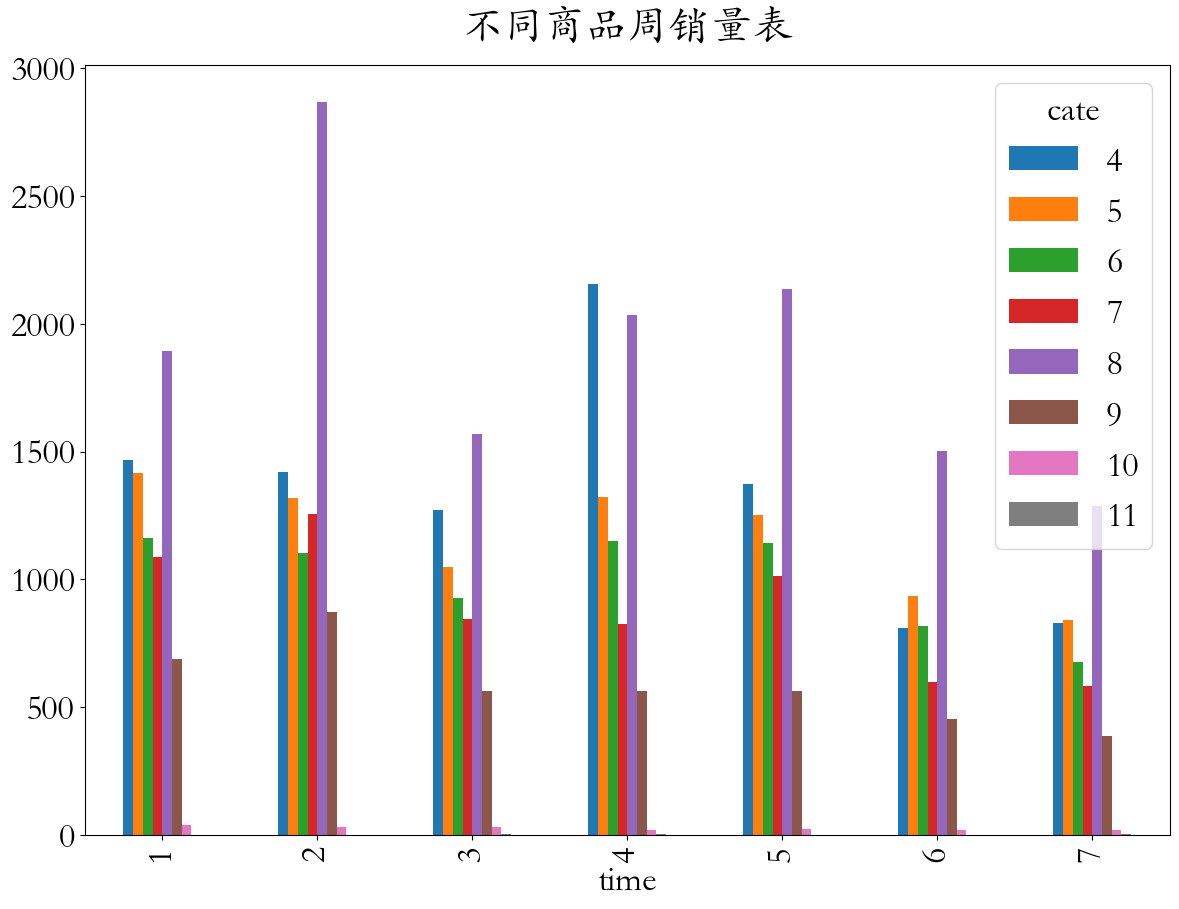

In [33]:
# 周一到周日每天购买商品类别数量统计
plt.rcParams['font.family'] = 'STKaiti'
plt.rcParams['font.size'] = 25

df_product = df_ac['brand'].groupby([df_ac['time'],
                                   df_ac['cate']]).count()

df_product = df_product.unstack()

df_product.plot(kind='bar',figsize=(14,10))
_ = plt.title(label='不同商品周销量表',pad=20)

In [34]:
df_ac

,cate,brand,type,time
0,9,306,4,1
1,4,174,4,1
2,5,78,4,1
3,5,78,4,1
4,4,306,4,1
...,...,...,...,...
48247,8,214,4,5
48248,5,306,4,5
48249,8,214,4,5
48250,6,306,4,5


In [39]:
df_product = df_ac['brand'].groupby([df_ac['time'],
                                      df_ac['cate']]).count()
df_product.head(10)

time  cate
1     4       1466
      5       1417
      6       1162
      7       1089
      8       1892
      9        691
      10        39
      11         3
2     4       1421
      5       1320
Name: brand, dtype: int64

In [40]:
df_product.unstack()

cate,4,5,6,7,8,9,10,11
time,,,,,,,,
1,1466.0,1417.0,1162.0,1089.0,1892.0,691.0,39.0,3.0
2,1421.0,1320.0,1103.0,1255.0,2866.0,872.0,32.0,NaN
3,1270.0,1048.0,929.0,846.0,1567.0,566.0,32.0,4.0
4,2155.0,1321.0,1149.0,827.0,2034.0,566.0,20.0,6.0
5,1373.0,1253.0,1141.0,1012.0,2135.0,566.0,25.0,NaN
6,811.0,937.0,820.0,601.0,1501.0,453.0,20.0,NaN
7,830.0,842.0,678.0,584.0,1286.0,390.0,21.0,5.0


分析:星期二类别8购买最多，星期天最少

## 5 每月各类商品的销售情况

### 5.1 加载全部数据

In [42]:
df_ac2 = get_from_action_data(fname=ACTION_201602_FILE)
df_ac2['time'] = pd.to_datetime(df_ac2['time']).apply(lambda x: x.day)

df_ac3 = get_from_action_data(fname=ACTION_201603_FILE)
df_ac3['time'] = pd.to_datetime(df_ac3['time']).apply(lambda x: x.day)

df_ac4 = get_from_action_data(fname=ACTION_201604_FILE)
df_ac4['time'] = pd.to_datetime(df_ac4['time']).apply(lambda x: x.day)

Iteration is stooped
Iteration is stooped
Iteration is stooped


### 5.2 商品8按月份销售数据按天分组聚合统计销量

In [43]:
dc_cate2 = df_ac2[df_ac2['cate']==8]
dc_cate2 = dc_cate2['brand'].groupby(dc_cate2['time']).count()
display(dc_cate2.head())
dc_cate2 = dc_cate2.to_frame().reset_index()
display(dc_cate2.head())
dc_cate2.columns = ['day','product_num']

dc_cate3 = df_ac3[df_ac3['cate']==8]
dc_cate3 = dc_cate3['brand'].groupby(dc_cate3['time']).count()
display(dc_cate3.head())
dc_cate3 = dc_cate3.to_frame().reset_index()
display(dc_cate3.head())
dc_cate3.columns = ['day','product_num']

dc_cate4 = df_ac4[df_ac4['cate']==8]
dc_cate4 = dc_cate4['brand'].groupby(dc_cate4['time']).count()
display(dc_cate4.head())
dc_cate4 = dc_cate4.to_frame().reset_index()
display(dc_cate4.head())
dc_cate4.columns = ['day','product_num']

time
1    90
2    84
3    78
4    47
5    26
Name: brand, dtype: int64

,time,brand
0,1,90
1,2,84
2,3,78
3,4,47
4,5,26


time
1    284
2    186
3    199
4    175
5    195
Name: brand, dtype: int64

,time,brand
0,1,284
1,2,186
2,3,199
3,4,175
4,5,195


time
1    208
2    199
3    174
4    175
5    181
Name: brand, dtype: int64

,time,brand
0,1,208
1,2,199
2,3,174
3,4,175
4,5,181


### 5.3 商品8按天统计销量可视化

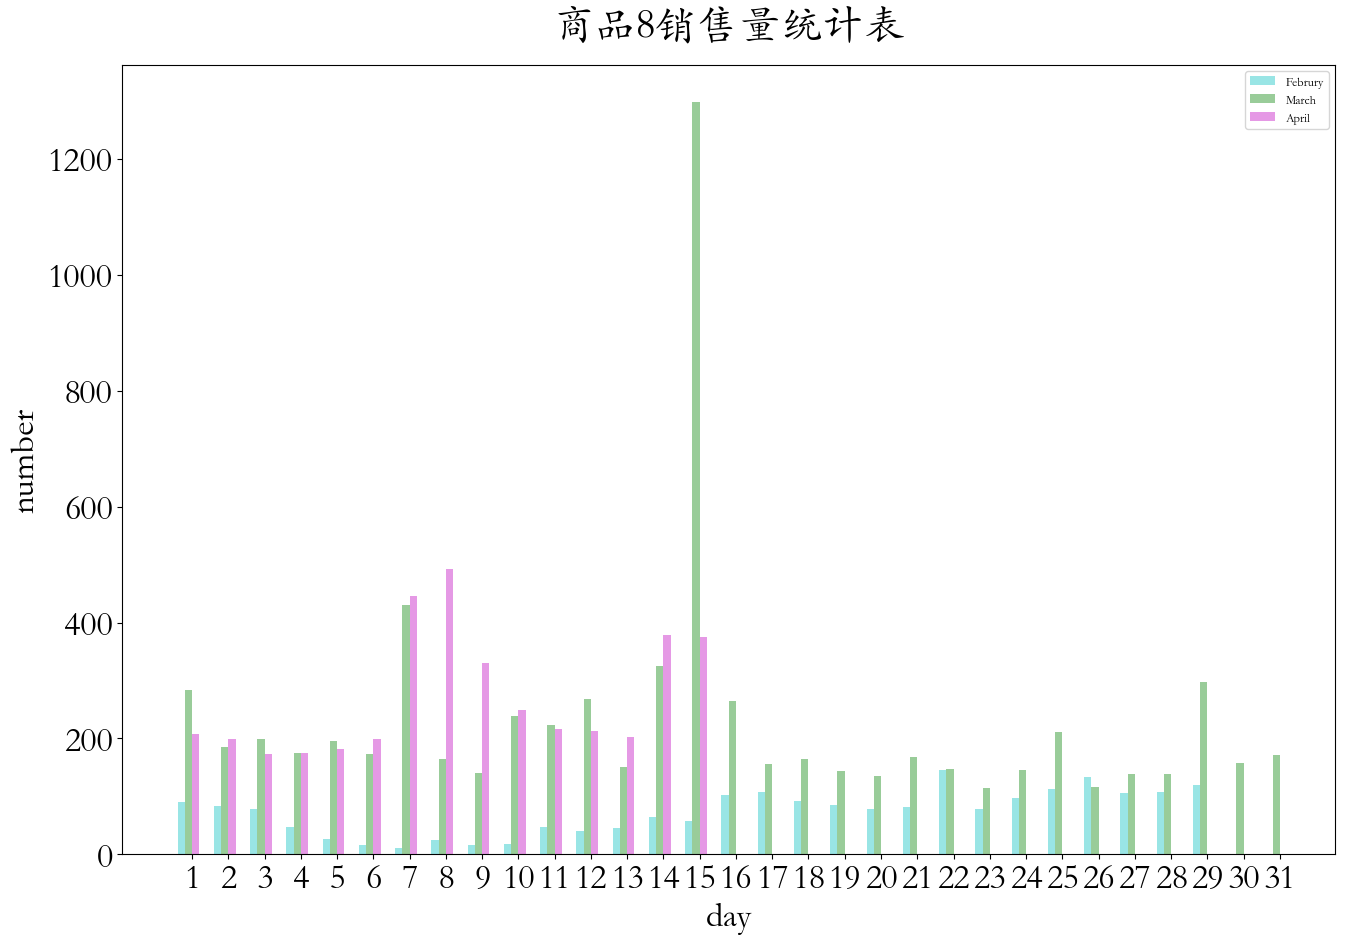

In [47]:
# 条形宽度
bar_width = 0.2
# 透明度
opacity = 0.4
# 天数
day_range = range(1,len(dc_cate3['day'])+1,1)
plt.rcParams['font.family'] = 'STKaiti'
plt.rcParams['font.size'] =25
# 设置图片大小
plt.figure(figsize=(14,10))

plt.bar(dc_cate2['day'],dc_cate2['product_num'],bar_width,
       alpha=opacity,color='c',label='Februry')

plt.bar(dc_cate3['day']+bar_width,dc_cate3['product_num'],bar_width,
       alpha=opacity,color='g',label='March')

plt.bar(dc_cate4['day']+bar_width*2,dc_cate4['product_num'],bar_width,
       alpha=opacity,color='m',label='April')

plt.xlabel('day')
plt.ylabel('number')
plt.title('商品8销售量统计表',pad=20)
plt.xticks(dc_cate3['day']+bar_width*3/2,day_range)
plt.tight_layout()

plt.legend(prop={'size':9})

## 6.查看特定用户对特定商品的轨迹

### 6.1 定义函数筛选用户--商品数据

In [56]:
def spec_ui_action_data(fname,user_id,sku_id,chunk_size=100000):
    reader = pd.read_csv(fname,header=0,iterator=True)
    chunks = []
    loop=True
    while loop:
        try:
            chunk = reader.get_chunk(chunk_size)[
                ["user_id","sku_id","type","time"]]
            chunks.append(chunk)
        except StopIteration:
            loop = False
            print("Iteration is stopped")
    df_ac = pd.concat(chunks,ignore_index=True)
    df_ac = df_ac[(df_ac['user_id'] == user_id)&(df_ac['sku_id']==sku_id)]
    
    return df_ac

### 6.2 筛选特定用户特定商品的全部数据

In [57]:
def explore_user_item_via_item():
    user_id = 266079
    sku_id = 138778
    df_ac=[]
    
    df_ac.append(spec_ui_action_data(ACTION_201602_FILE,user_id,sku_id))
    df_ac.append(spec_ui_action_data(ACTION_201603_FILE,user_id,sku_id))
    df_ac.append(spec_ui_action_data(ACTION_201604_FILE,user_id,sku_id))
    
    
    df_ac = pd.concat(df_ac,ignore_index=False)
    print(df_ac.sort_values(by='time'))

### 6.3 进行用户和商品数据筛选

In [58]:
explore_user_item_via_item()

Iteration is stopped
Iteration is stopped
Iteration is stopped
    user_id  sku_id  type                 time
0    266079  138778     1  2016-01-31 23:59:02
1    266079  138778     6  2016-01-31 23:59:03
15   266079  138778     6  2016-01-31 23:59:40
